#### Steps to create mutual information
0. separating target to y, features to X
1. convert category features to integers using factorize() method
2. use sklearn.feature_selection mutual_info_regression to create mi_score
3. view and plot mi score

In [121]:
# import jlam.nbdev as nbdev
# nbdev.parse_nb('mutual_info_util_build.ipynb','/Users/i846240/src/jlam/ml/features_selection/mutual_info_util.py')

In [67]:
#<<export>>
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import mutual_info_regression

In [74]:
from ipywidgets import interact
import jlam.eda_util as edu
pd.set_option('display.max_rows',500)
pd.options.display.float_format='{:,.02f}'.format

In [25]:
def make_mi_scores(X, y):
    """
        calculate mutual information scores
        X: features
        y: target measure (regression)
        return: series with features as index and mi scores as values
    """
    X = X.copy()
    
    # convert category features to numeric
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
        
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    # calculate scores and create series using features as indexes and scores as values
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [65]:
def plot_mi_scores(plt,scores,width=10,height=15):
    """
        plot horizontal bar graph using mi score series
        plt: pyplot
        scores: Series containing features and scores
        width: figure width
        height: figure height
    """
    fig = plt.figure(figsize=(width,height))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [43]:
# constants
TARGET = 'price'

In [27]:
df = pd.read_csv('data/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          193 non-null    int64  
 1   make               193 non-null    object 
 2   fuel_type          193 non-null    object 
 3   aspiration         193 non-null    object 
 4   num_of_doors       193 non-null    int64  
 5   body_style         193 non-null    object 
 6   drive_wheels       193 non-null    object 
 7   engine_location    193 non-null    object 
 8   wheel_base         193 non-null    float64
 9   length             193 non-null    float64
 10  width              193 non-null    float64
 11  height             193 non-null    float64
 12  curb_weight        193 non-null    int64  
 13  engine_type        193 non-null    object 
 14  num_of_cylinders   193 non-null    int64  
 15  engine_size        193 non-null    int64  
 16  fuel_system        193 non

In [45]:
def view_histograms(df,plt):
    # distributions for all numeric features
    fig = plt.figure(figsize = (15,20))
    ax = fig.gca()
    df.hist(ax = ax);

In [46]:
# separating X and y
X = df.copy()
y = X.pop('price')

In [47]:
# view dtypes for X
set(X.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [114]:
def convert_discrete_features(X):
    """ 
        convert discrete features to numeric
        X: df with features
        return: df with cat features converted
    """
    cols_cat = X.select_dtypes(['object','category'])
    for c in cols_cat:
        X[c], _ = X[c].factorize()
    return X
    

In [58]:
# convert discrete features and make sure everything is numeric
X = convert_discrete_features(X)
# discrete_features = X.dtypes==int
set(X.dtypes)

{dtype('int64'), dtype('float64')}

In [59]:
# get scores
mi_scores = make_mi_scores(X,y)

Checking X array...


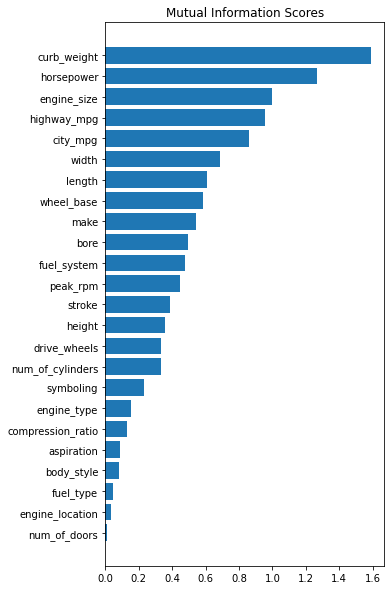

In [66]:
# plot scores
plot_mi_scores(plt,mi_scores,5,10)

# Test with dacv info

In [84]:
df_hana = pd.read_pickle('../../sap/deployed_acv_vs2/data/validation/hana_view_new.pkl')
df_hana['DTI_DAYS']=df_hana['DTI_DAYS'].astype('float64')
df_deployed = df_hana.query('ACV >= 0.0 and DTI_DAYS >= 0.0 and LOB != "Training & Adoption"').copy()
df_deployed.reset_index(inplace=True)
dfs_deployed = edu.df_summary(df_deployed)


In [85]:
@interact

def show_summary(sorted_by=dfs_deployed.columns.to_list(),ascend=[True,False]):
    print(dfs_deployed.sort_values(by=[sorted_by],ascending=ascend))

interactive(children=(Dropdown(description='sorted_by', options=('column', 'types', 'distinct', 'count_na', 'p…

### View DTI distribution by LOB

<AxesSubplot:xlabel='DTI_DAYS', ylabel='LOB'>

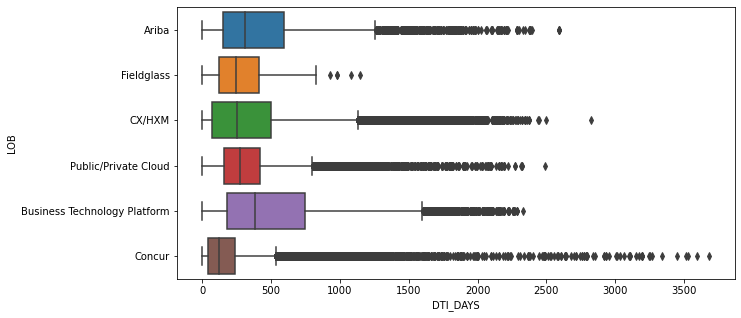

In [86]:

fig,ax = plt.subplots(1, figsize=(10, 5))
sns.boxplot(data=df_deployed,y='LOB',x='DTI_DAYS')

### Products by LOB

In [88]:
df_deployed.groupby('LOB')['LOGICAL_PRODUCT_ID'].nunique().sort_values(ascending=False)

LOB
Public/Private Cloud            152
CX/HXM                           76
Business Technology Platform     69
Ariba                            30
Concur                           20
Fieldglass                        5
Name: LOGICAL_PRODUCT_ID, dtype: int64

### Any relationship between # of products and DTI std?

Text(0.5, 1.0, 'deployed ACV product_count by LOB vs DTI std')

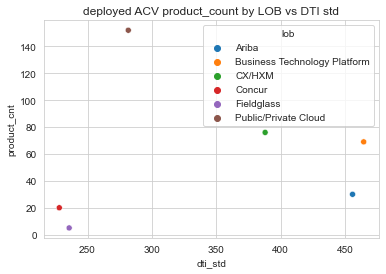

In [126]:
sns.set_style('whitegrid')
df0=df_deployed.groupby('LOB').agg({'LOGICAL_PRODUCT_ID':'nunique','DTI_DAYS':'std'}).reset_index()
df0.columns=['lob','product_cnt','dti_std']
p=sns.scatterplot(data=df0,x='dti_std',y='product_cnt',hue='lob')
p.set_title('deployed ACV product_count by LOB vs DTI std')

### Drop those with lots of nulls

In [110]:
cols_to_keep = list(dfs_deployed.query('percent_na <= 2.0 and distinct < 450 and distinct >2')['column'].values)
cols_to_keep.pop(0)
cols_to_keep.append('DTI_DAYS')
# cols_to_keep
df_base=df_deployed[cols_to_keep].copy()
df_base.fillna(value='n/a',inplace=True)

In [111]:
edu.df_summary(df_base)

,column,types,distinct,count_na,percent_na
0,DEPLOYED_BY,object,6,0,0.00
1,LOB,object,6,0,0.00
2,REGION,object,8,0,0.00
3,MARKET_UNIT,object,33,0,0.00
4,YEAR_QUATER,object,34,0,0.00
5,LOCAL_CURRENCY,object,37,0,0.00
6,LOGICAL_PRODUCT_ID,object,352,0,0.00
7,DTI_DAYS,float64,2107,0,0.00


In [104]:
set(df_base.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [112]:
X = df_base.copy()
y = X.pop('DTI_DAYS')

In [115]:
X = convert_discrete_features(X)

In [116]:
mi_scores = make_mi_scores(X,y)

Checking X array...


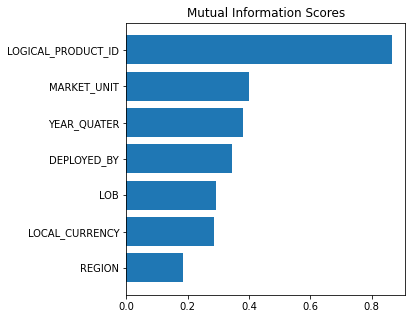

In [118]:
plot_mi_scores(plt,mi_scores,5,5)